BloomTech Data Science

*Unit 2, Sprint 1, Module 4*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.* 

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [2]:
# Import libraries for this project
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


# I. Wrangle Data

In [3]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')
    
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL'])

    # Cleaning binary columns
    # Encode binary topping columns
    binary_cols = ['NonSD', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
                    'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce',
                    'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
                    'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
                    'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom', 'Bacon', 'Sushi',
                    'Avocado', 'Corn', 'Zucchini', 'Chips']

    df[binary_cols] = df[binary_cols].applymap(lambda x:1 if type(x) == str else 0)
    
    # Feature Engineering
    # Create pseudo one-hot encoded categories for 'Burrito'
    burrito_type = ['california', 'asada', 'surf', 'carnitas']

    for b in burrito_type:
      df[b] = df['Burrito'].str.lower().str.contains(b).astype(int)

    # # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall', 'Burrito']) 


    return df

filepath = DATA_PATH + 'burritos/burritos.csv'

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [4]:
# Check dataframe withouth wrangle function
df = pd.read_csv(filepath)
print(df.shape)
df.head()

(423, 66)


,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,...,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Load data using wrangle function
df = wrangle(filepath)

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [6]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

# Print the first five rows of dataset and its shape
print(df.shape)
df.head()

(421, 63)


,Neighborhood,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,...,Bacon,Sushi,Avocado,Corn,Zucchini,Great,california,asada,surf,carnitas
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,Miramar,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2016-01-24,San Marcos,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2016-01-24,NaN,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2016-01-24,NaN,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2016-01-27,Carlsbad,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1,0,0,0


In [7]:
# Check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Neighborhood    92 non-null     object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           421 non-null    int64  
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

In [8]:
# Check values for 'beef' feature
df['Beef'].head()

Date
2016-01-18    1
2016-01-24    1
2016-01-24    0
2016-01-24    1
2016-01-27    1
Name: Beef, dtype: int64

In [9]:
df['Beef'].value_counts()

0    242
1    179
Name: Beef, dtype: int64

In [10]:
# Check columns that could potentially be binary encoded
# df.select_dtypes('object').info()

In [11]:
# We want all the columns from 22 to up to but not including the last column + chips
# df.iloc[:, 22:-1].head().columns

In [12]:
# Columns we need to change
# binary_cols = ['NonSD', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream',
#               'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice', 'Beans', 'Lettuce',
#               'Tomato', 'Bell peper', 'Carrots', 'Cabbage', 'Sauce', 'Salsa.1',
#               'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
#               'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom', 'Bacon', 'Sushi',
#               'Avocado', 'Corn', 'Zucchini', 'Chips']

In [13]:
# Total null values
print('Total Null Values:',df.isna().sum().sum())
df.isna().sum()

Total Null Values: 2690


Neighborhood    329
Yelp            334
Google          334
Chips             0
Cost              7
               ... 
Great             0
california        0
asada             0
surf              0
carnitas          0
Length: 63, dtype: int64

In [14]:
# df['Beef'].apply(lambda x:1 if type(x)== str else 0).head(10)

In [15]:
# Process to transform binary columns from string and null values to 0 and 1 (boolean)
# df[binary_cols].applymap(lambda x:1 if type(x)== str else 0).head(10)

If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

In [17]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

# Check Burrito feature for high cardinality
# df['Burrito'].nunique()
# df['Burrito'].head(10)

In [18]:
# Feature Engineering
# burrito_type = ['california', 'asada', 'surf', 'carnitas']
# # df['Burrito'].str.lower().str.contains(burrito_type[0]).astype(int).head(10)

# for b in burrito_type:
#   df[b] = df['Burrito'].str.lower().str.contains(b).astype(int)

# df[['california', 'asada', 'surf', 'carnitas']].head()

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [19]:
target = 'Great'
X = df.drop(columns=target)
y = df[target]

In [20]:
# Check shape of the feature matrix and target vector
X.shape, y.shape #X is 2D, y is 1D

((421, 62), (421,))

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [21]:
cutoff = '2018-01-01'
mask = X.index < cutoff

X_train, y_train =  X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask] #invert the mask

In [22]:
# Sanity check
assert len(X_train) + len(X_test) == len(X)


# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [23]:
baseline_acc = y_train.value_counts(normalize=True).max() # majority class
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5822454308093995


**Insights:** 58% of the burritos in this study are not great. This means that if we guess not great every time we eat a burrito or predict not great, we will be right arounfd 58% of the time.

# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [24]:
# Build pipeline
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
    )

# Fit model to the training data
model_logr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Neighborhood', 'Reviewer', 'Unreliable'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [25]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test, y_test)

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.97911227154047
Test MAE: 0.7894736842105263


**Insights:** The training accuracy is really good at 0.97, but the test accuracy is not as good at 0.79. The model has good performance and is beating the baseline however, it's not generalizing very well.

# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

In [26]:
# Create your horizontal barchart here.
coefficients = model_logr.named_steps['logisticregression'].coef_[0]
coefficients

array([ 9.77976394e-02, -2.73913262e-01, -6.22782322e-02,  1.10676621e-01,
        4.54389005e-01,  1.58499276e-02, -1.53627222e-01,  9.38795909e-02,
        4.21065873e-01,  5.97207248e-01,  1.62186386e-01, -6.30011752e-02,
       -2.87040573e-03,  2.02587449e-01, -3.61316347e-03, -3.66965699e-02,
        9.62162264e-02,  1.36538303e-01, -3.36397467e-01,  3.97151693e-01,
       -3.21483180e-03, -2.54774833e-01, -8.57161273e-02, -4.17885747e-01,
       -1.90490133e-01,  4.89892769e-03,  2.60462910e-05,  2.72037574e-01,
       -4.76844773e-04, -4.05144866e-02, -2.87431374e-01, -6.73482252e-03,
       -5.74610466e-03,  7.31677116e-02, -5.97916424e-03,  2.20529964e-02,
       -3.56126607e-05, -5.80095460e-03, -2.06620543e-02, -5.11068056e-02,
       -5.27113721e-02,  6.93213523e-01, -7.93637262e-01, -1.27942619e-01,
        5.61837572e-01, -6.49453758e-02, -5.03974894e-01,  1.43696619e-01,
        2.44211024e-01, -1.16498700e-01, -3.18503999e-01,  5.61249218e-01,
        9.66987591e-01,  

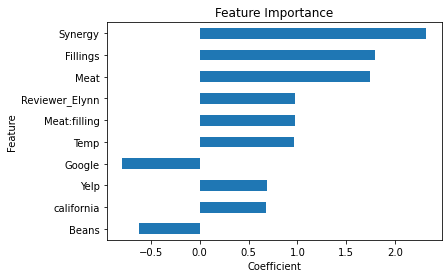

In [27]:
features = model_logr.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance');

**Insights:**
- We can see that the most important feature is synergy. 
- It seems that as Google rating increases, the quality of the burrito decreases.
- Elynn seems to improve the greatness of a burrito, which tells us that maybe Eileen is a little bit of a biased reviewer.


There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output? 
- What are the shapes of their different output? predict =
- What numerical values are in the output? 
- What do those numerical values represent? 

In [28]:
# Write code here to explore the differences between `predict` and `predict_proba`.
y_pred = model_logr.predict(X_test)
print(y_pred)

[1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1
 1]


In [29]:
# predict shape
y_pred.shape

(38,)

In [35]:
# predict data type
y_pred.dtype

dtype('int64')

In [33]:
y_pred_prob = np.round(model_logr.predict_proba(X_test)[:, -1], 2)
print(y_pred_prob)

[1.   1.   0.01 1.   0.   0.14 0.98 1.   1.   0.93 0.69 0.   0.44 0.61
 0.99 0.98 0.95 0.   0.01 0.   0.   0.99 0.05 0.93 0.68 0.19 0.   1.
 0.93 1.   0.01 0.92 0.99 0.   0.69 0.83 1.   0.99]


In [34]:
# predict_prob shape
y_pred_prob.shape

(38,)

In [36]:
# predict_prob data type
y_pred_prob.dtype

dtype('float64')

**Give your written answer here:**

- What data type do `predict` and `predict_proba` output? 

  **Answer:** Both `predict` and `predict_proba`are arrays.

- What are the shapes of their different output?

  **Answer:** `predict` is a one-dimensional array ; `predict_proba` is a two-dimensional array.

- What numerical values are in the output? 

  **Answer:** `predict` values are integers, while `predict_proba` values are floats.

- What do those numerical values represent? 

  **Answer:** `predict` represents whether or not a burrito is great and,
`predict_proba` represents the model's degree of certainty that a burrito is great.